In [74]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [75]:
original_data = pd.read_parquet(r'../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v4_TOTALS.parquet')
original_data.head()

,Area,Year,Area Code,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No,Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt,Farm_gate_Emissions_(CO2eq)_(AR5)_kt,Land_Use_change_Emissions_(CO2eq)_(AR5)_kt,Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt
0,Armenia,1980,1,3574.555,2997.3446,2107.216,54.2254,835.9032
1,Armenia,1981,1,3574.555,2997.3446,2107.216,54.2254,835.9032
2,Armenia,1982,1,3574.555,2997.3446,2107.216,54.2254,835.9032
3,Armenia,1983,1,3574.555,2997.3446,2107.216,54.2254,835.9032
4,Armenia,1984,1,3574.555,2997.3446,2107.216,54.2254,835.9032


# Clean up country names

In [76]:
data = original_data.copy()
data = data[data['Area Code'] < 1000] # Select only countries
data.rename(columns = {'Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No':'Population_1000s'}, inplace = True)

Filter geopandas countries

In [77]:
country_codes = pd.read_csv('../data/FAOSTAT/clean_data/fao_country_codes_corrected.csv')

# Group by 'Area' and 'Area Code', then count the number of unique Area Codes for each Area
area_code_counts = country_codes.groupby('Area')['Area Code'].nunique()

# Filter areas with more than one unique area code
areas_with_multiple_codes = area_code_counts[area_code_counts > 1]

# Display results
print(areas_with_multiple_codes)

Series([], Name: Area Code, dtype: int64)


In [78]:
print(f"Initial Nr. of Unique Countries and Country Codes: {data['Area'].nunique()} | {data['Area Code'].nunique()}")

# Merge with corrected countries to filter
data = pd.merge(data.drop('Area', axis=1), country_codes, how='left', on='Area Code')

# Correct some data
data['Area'] = np.where(data['Area Code'] == 351, 'China', data['Area'])
data = data.dropna(subset=['Area'])

# Drop USSR and Yugoslav SFR. Drop China Mainland and keep only China
data = data[~data['Area'].isin(['USSR', 'Yugoslav SFR'])]
data = data[data['Area Code'] != 41]

# After filtering
print(f"Final Nr. of Unique Countries and Country Codes: {data['Area'].nunique()} | {data['Area Code'].nunique()}")

Initial Nr. of Unique Countries and Country Codes: 243 | 243
Final Nr. of Unique Countries and Country Codes: 203 | 203


In [79]:
# cluster_columns = [
#     'Fertilizers_Manufacturing_Emissions_(CO2eq)_(AR5)_kt_x',
#     'Pesticides_Manufacturing_Emissions_(CO2eq)_(AR5)_kt_x',
#     'Solid_Food_Waste_Emissions_(CO2eq)_(AR5)_kt',
#     'Food_Packaging_Emissions_(CO2eq)_(AR5)_kt_y',
#     'Food_Processing_Emissions_(CO2eq)_(AR5)_kt_y',
#     'Food_Retail_Emissions_(CO2eq)_(AR5)_kt_y',
#     'Food_Transport_Emissions_(CO2eq)_(AR5)_kt_y',
#     'Net_Forest_conversion_Emissions_(CO2eq)_(AR5)_kt',
#     'Fires_in_humid_tropical_forests_Emissions_(CO2eq)_(AR5)_kt',
#     'Fires_in_organic_soils_Emissions_(CO2eq)_(AR5)_kt',
#     'Forest_fires_Emissions_(CO2eq)_(AR5)_kt',
#     'Savanna_fires_Emissions_(CO2eq)_(AR5)_kt',
#     'Drained_organic_soils_Emissions_(CO2)_kt',
#     "Enteric_Fermentation_Emissions_(CO2eq)_(AR5)_kt",
#     "Manure_Management_Emissions_(CO2eq)_(AR5)_kt",
#     "Manure_applied_to_Soils_Emissions_(CO2eq)_(AR5)_kt",
#     "Manure_left_on_Pasture_Emissions_(CO2eq)_(AR5)_kt",
#     'Crop_Residues_Emissions_(CO2eq)_(AR5)_kt',
#     'Burning_-_Crop_residues_Emissions_(CO2eq)_(AR5)_kt',
#     'Rice_Cultivation_Emissions_(CO2eq)_(AR5)_kt',
#     'Synthetic_Fertilizers_Emissions_(CO2eq)_(AR5)_kt',    
# ]

cluster_columns = [
    # 'Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt',
 'Farm_gate_Emissions_(CO2eq)_(AR5)_kt',
 'Land_Use_change_Emissions_(CO2eq)_(AR5)_kt',
 'Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt'
]

core_cols = ['Area', 'Area Code', 'Population_1000s']
group_cols = ['Area', 'Area Code']

In [80]:
grouped_data = data[cluster_columns+core_cols].groupby(group_cols).sum().reset_index()
grouped_data = grouped_data[grouped_data['Population_1000s'] > 0]

In [81]:
grouped_data.shape

(202, 6)

In [82]:
grouped_data = grouped_data.set_index(group_cols)
grouped_data.sum(axis=1).sort_values(ascending=False).head(20)

Area                      Area Code
China                     351          1.132418e+08
India                     100          7.865006e+07
Brazil                    21           6.667265e+07
Indonesia                 101          4.426297e+07
United States of America  231          4.417591e+07
Russia                    185          2.490933e+07
Dem. Rep. Congo           250          1.862535e+07
Pakistan                  165          1.277255e+07
Mexico                    138          1.114724e+07
Japan                     110          1.059712e+07
Nigeria                   159          1.039597e+07
Argentina                 9            1.030868e+07
Germany                   79           1.020560e+07
Canada                    33           1.006785e+07
Australia                 10           9.350864e+06
Bangladesh                16           9.274949e+06
France                    68           8.463674e+06
Myanmar                   28           8.441513e+06
Ethiopia                  23

In [83]:
# # Filter countries with low emissions
low_emission_countries = grouped_data.sum(axis=1)[grouped_data.sum(axis=1) < 1000].index.tolist()
grouped_data = grouped_data[~grouped_data.index.isin(low_emission_countries)]

# Calculate also per capita emissions (Clustering done with both: total and per capita)

In [84]:
new_cluster_cols = []

for col in cluster_columns:
    per_capita_col = f"{col}_per-capita"
    grouped_data[per_capita_col] = grouped_data[col].div((grouped_data['Population_1000s']*1000))
    new_cluster_cols.append(per_capita_col)
    
cluster_columns += new_cluster_cols

# Is data normally distributed

In [85]:
# # Original data
# for col in grouped_data.columns.tolist()[:5]:
#     grouped_data[col].hist()
#     print(col)
#     plt.show()

In [86]:
# # Extract the selected columns
# data_subset = grouped_data[cluster_columns]

# # Apply log1p transformation
# log1p_data_subset = np.log1p(data_subset)

# # Plot histograms for each transformed column
# for col in cluster_columns:
#     plt.figure(figsize=(8, 4))
#     plt.hist(log1p_data_subset[col], bins=20, edgecolor='k')
#     plt.title(f'Histogram of log1p Transformed {col}')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.show()


# K-means with log normalization (per capita emissions)

So I drop population

In [87]:
kmeans_data = grouped_data.drop('Population_1000s', axis=1)

Fitting data with 2 clusters
Fitting data with 3 clusters
Fitting data with 4 clusters
Fitting data with 5 clusters
Fitting data with 6 clusters
Fitting data with 7 clusters
Fitting data with 8 clusters
Fitting data with 9 clusters
Fitting data with 10 clusters
Fitting data with 11 clusters
Fitting data with 12 clusters
Fitting data with 13 clusters
Fitting data with 14 clusters
Fitting data with 15 clusters
Fitting data with 16 clusters
Fitting data with 17 clusters
Fitting data with 18 clusters
Fitting data with 19 clusters


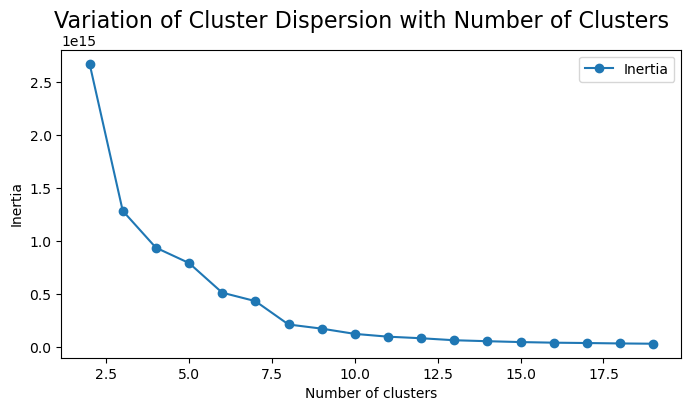

cluster
0    193
1      3
3      2
2      1
Name: count, dtype: int64
Cluster 0:
[('Afghanistan', 2), ('Albania', 3), ('Algeria', 4), ('Angola', 7), ('Antigua and Barbuda', 8), ('Argentina', 9), ('Armenia', 1), ('Australia', 10), ('Austria', 11), ('Azerbaijan', 52), ('Bahamas', 12), ('Bahrain', 13), ('Bangladesh', 16), ('Barbados', 14), ('Belarus', 57), ('Belgium', 255), ('Belize', 23), ('Benin', 53), ('Bhutan', 18), ('Bolivia', 19), ('Bosnia and Herz.', 80), ('Botswana', 20), ('Brunei', 26), ('Bulgaria', 27), ('Burkina Faso', 233), ('Burundi', 29), ('Cabo Verde', 35), ('Cambodia', 115), ('Cameroon', 32), ('Canada', 33), ('Central African Rep.', 37), ('Chad', 39), ('Chile', 40), ('Colombia', 44), ('Comoros', 45), ('Congo', 46), ('Cook Islands', 47), ('Costa Rica', 48), ('Croatia', 98), ('Cuba', 49), ('Cyprus', 50), ('Czechia', 167), ('Czechoslovakia', 51), ('Denmark', 54), ('Djibouti', 72), ('Dominica', 55), ('Dominican Rep.', 56), ('Ecuador', 58), ('Egypt', 59), ('El Salvador', 60), (

In [88]:
# Dictionary to store SSE values
sse = {}

for k in range(2, 20):
    print(f"Fitting data with {k} clusters")

    kmeans = KMeans(n_clusters=k, random_state=23)
    kmeans.fit(kmeans_data)

    sse[k] = kmeans.inertia_

# Plotting
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, marker='o', linestyle='-', label="Inertia")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")
fig.suptitle("Variation of Cluster Dispersion with Number of Clusters", fontsize=16)
plt.legend()
plt.show()

# Apply KMeans with 10 clusters on the scaled log1p-transformed data
kmeans = KMeans(n_clusters=4, random_state=23).fit(kmeans_data)

# Add cluster labels to the DataFrame
grouped_data['cluster'] = kmeans.labels_
print(grouped_data['cluster'].value_counts())

for cluster in grouped_data['cluster'].unique():
    print(f"Cluster {cluster}:\n{grouped_data[grouped_data['cluster'] == cluster].index.tolist()}\n")

# Save data for choropleth map

In [92]:
data_with_clusters = data.copy()
grouped_data = grouped_data.reset_index()[['Area', 'cluster']]

data_with_clusters = pd.merge(data_with_clusters, grouped_data, on='Area', how='inner')

data_with_clusters.to_parquet('../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v4_TOTALS_with_clusters.parquet', index=False)

In [93]:
data_with_clusters['Area'].nunique()

199